<a href="https://colab.research.google.com/github/RxnAch/ProjectsOnDeepLearning/blob/main/Chest_X_Ray_Images(Pneumonia).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io, transform 
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets,models,transforms

#Load Dataset 
- test set
- train set
- validation set

In [2]:
data_dir = "/content/drive/MyDrive/datasets/kaggle_dataset/ChestXray/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL = 'val'

#Data Preprocessing and Augmentation

Deeplearning models requires a lot of data.In fact,the more the data,the better the performance of the model.

Image Augmentation is the process of generating new images for training our deep learning models. These images are generated using the existing training images and hence we don't have to collect them manually.

**transforms.Compose** just clubs all the transforms provided to it. So, all the transforms in the transforms.Compose are applied to the input one by one.

#**Train transforms**
**transforms.RandomResizedCrop(224)**:

 This will extract a patch of size (224, 224) from your input image randomly. So, it might pick this path from topleft, bottomright or anywhere in between. So, you are doing data augmentation in this part. Also, changing this value won't play nice with the fully-connected layers in your model, so not advised to change this.

**transforms.RandomHorizontalFlip():** 

Once we have our image of size (224, 224), we can choose to flip it. This is another part of data augmentation.
transforms.ToTensor(): This just converts your input image to PyTorch tensor.


**transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):** This is just input data scaling and these values (mean and std) must have been precomputed for your dataset. Changing these values is also not advised.

#**Validation transforms**
**transforms.Resize(256):**

 First your input image is resized to be of size (256, 256)
**transforms.CentreCrop(224):** 

Crops the center part of the image of shape (224, 224)

In [3]:
def data_transforms(phase):
  if phase == TRAIN:
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
  if phase == VAL:
    transform = transforms.Compose([
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

  if phase == TEST:
    transform = transforms.Compose([
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

  return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms(x))
                  for x in [TRAIN,VAL,TEST]}
dataloaders = {
    TRAIN:torch.utils.data.DataLoader(image_datasets[TRAIN],batch_size = 4,shuffle = True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL],batch_size = 1,shuffle=True),
    TEST :torch.utils.data.DataLoader(image_datasets[TEST],batch_size=1,shuffle = True)
}

In [5]:
len(dataloaders[TRAIN]),len(dataloaders[TEST]),len(dataloaders[VAL])

(1304, 624, 16)

In [6]:
dataset_sizes = {x:len(image_datasets[x]) for x in [TRAIN,VAL]}
classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

#Visualize the Chest X-rays

[transpose](https://stackoverflow.com/questions/32034237/how-does-numpys-transpose-method-permute-the-axes-of-an-array)

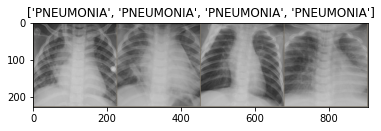

In [7]:
def imshow(inp,title = None):
  inp = inp.numpy().transpose((1,2,0)) 
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
inputs,classes = next(iter(dataloaders[TRAIN]))
out = torchvision.utils.make_grid(inputs)
imshow(out,title = [class_names[x] for x in classes])

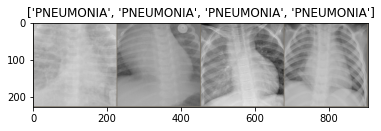

In [8]:
inputs,classes  = next(iter(dataloaders[TRAIN]))
out = torchvision.utils.make_grid(inputs)
imshow(out,title = [class_names[x] for x in classes])

#Define the function for Training

In [14]:
def train_model(model,criterion,optimizer,scheduler,num_epochs):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epochs):
    print("Epoch : {}/{}".format(epoch+1,num_epochs))
    print("="*10)
    #each epoch has a training and validation phase
    for phase in [TRAIN,VAL]:
      if phase == TRAIN:
        scheduler.step()
        model.train() #set model to training mode
      else:
        model.eval() #set model to evaluate mode
      running_loss = 0.0
      running_corrects = 0

      #iterate over data.
      for inputs,labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward
        #track history if only in train
        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _,preds = torch.max(outputs,1)
          loss = criterion(outputs,labels)

          #backward + optimize only in training phase
          if phase =='train':
            loss.backward()
            optmizer.step()
        running_loss+=loss.item()*inputs.size(0)
        running_corrects+=torch.sum(preds == labels.data)
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]

      print('{} Loss : {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))

      #deep copy the model
      if phase == 'val' and epoch_acc>best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())


  print('Best Val Acc: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)
  return model
